## Optuna: Next-Generation Hyperparameter Optimization

---
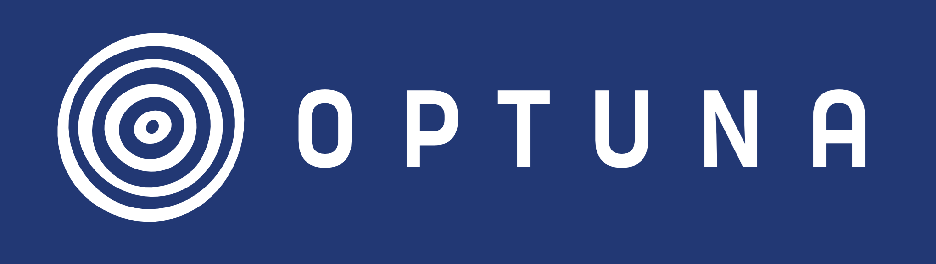

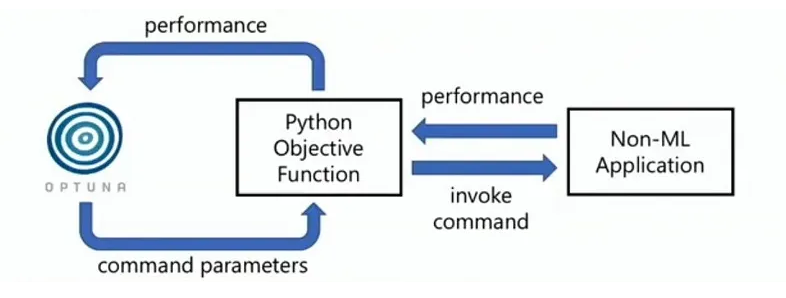

---

Optuna is an open-source hyperparameter optimization framework to automate hyperparameter search. 
Key features:
1. **Efficient Sampling:** Uses advanced algorithms like TPE (Tree-structured Parzen Estimator).
2. **Pruning:** Automatically stops unpromising trials early.
3. **Visualization:** Built-in functions to plot optimization history and parameter importance.

### Installation

In [ ]:
%%capture
# !pip install optuna plotly

In [33]:
import optuna
import pandas as pd
import numpy as np
import os
import webbrowser
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

## Loading and Preparing the Dataset
We use `Boston.csv` for a regression task. We apply **Mean Imputation** to handle any missing values, ensuring the optimization trials don't fail due to `NaN` inputs.

In [34]:
# Load dataset
df = pd.read_csv('./Data/Boston.csv')

# 1. Convert to numeric just in case there are hidden string '?' or ' ' values
df = df.apply(pd.to_numeric, errors='coerce')

# 2. Fill missing values with mean
df = df.fillna(df.mean())

# 3. Final safety check: Drop any row that still has a NaN (if mean was also NaN)
df = df.dropna()

X = df.drop('medv', axis=1) 
y = df['medv']

print(f"Data Cleaned! Final sample count: {len(df)}")

Data Cleaned! Final sample count: 506


### The Objective Function
We add a safety check inside the function. If the calculation returns `NaN`, we return a very high penalty value so Optuna knows that trial was unsuccessful.

In [35]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 50)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    # Using 3-Fold Cross Validation
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    
    # NaN Protection: If result is NaN, return a large number instead of failing
    if np.isnan(rmse):
        return 999999.0
        
    return rmse

### Executing the Optimization Study
We now run the study. Since we have protected the function from `NaN`, it will complete successfully.

In [36]:
# Initialize study
study = optuna.create_study(direction='minimize')

# Run 20 trials
study.optimize(objective, n_trials=50)

# Check if at least one trial succeeded
if len(study.trials) > 0:
    print("\n--- Optimization Summary ---")
    print(f"Best RMSE found: {study.best_value:.4f}")
    print(f"Best parameters: {study.best_params}")
else:
    print("Optimization failed to find a valid trial.")

[I 2026-02-05 19:51:05,992] A new study created in memory with name: no-name-9b609ecf-1aef-43de-ac37-5a3c4b3ee61f
[I 2026-02-05 19:51:06,192] Trial 0 finished with value: 6.710549824827211 and parameters: {'n_estimators': 44, 'max_depth': 2}. Best is trial 0 with value: 6.710549824827211.
[I 2026-02-05 19:51:06,506] Trial 1 finished with value: 5.706991450678718 and parameters: {'n_estimators': 49, 'max_depth': 10}. Best is trial 1 with value: 5.706991450678718.
[I 2026-02-05 19:51:06,673] Trial 2 finished with value: 5.802418342161271 and parameters: {'n_estimators': 37, 'max_depth': 5}. Best is trial 1 with value: 5.706991450678718.
[I 2026-02-05 19:51:06,856] Trial 3 finished with value: 5.720932277588052 and parameters: {'n_estimators': 24, 'max_depth': 8}. Best is trial 1 with value: 5.706991450678718.
[I 2026-02-05 19:51:07,048] Trial 4 finished with value: 5.717950639775 and parameters: {'n_estimators': 34, 'max_depth': 6}. Best is trial 1 with value: 5.706991450678718.
[I 2026-


--- Optimization Summary ---
Best RMSE found: 5.6773
Best parameters: {'n_estimators': 20, 'max_depth': 6}


### Exporting Interactive Visualizations to HTML

In [37]:
output_dir = './Output'
if not os.path.exists(output_dir): os.makedirs(output_dir)

history_path = os.path.abspath(os.path.join(output_dir, 'optuna_history_report.html'))
importance_path = os.path.abspath(os.path.join(output_dir, 'optuna_importance_report.html'))

# Generate Visuals
fig_hist = optuna.visualization.plot_optimization_history(study)
fig_imp = optuna.visualization.plot_param_importances(study)

# Save and Open
fig_hist.write_html(history_path, include_plotlyjs='cdn')
fig_imp.write_html(importance_path, include_plotlyjs='cdn')

webbrowser.open(f'file://{history_path}')
webbrowser.open(f'file://{importance_path}')

True